In [1]:
using DrWatson

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using LinearAlgebra, Pipe, Plots, ProgressMeter, Random
using PersistenceDiagrams, Ripserer, Statistics, StatsBase

In [3]:
function scale_embeddings(X)
    return StatsBase.standardize(ZScoreTransform, X, dims=1)
end

function diagram(X; dim_max)
    dgm = ripserer(X |> Alpha, dim_max=dim_max)
    [replace(x -> death(x) == Inf ? PersistenceInterval(birth(x), threshold(d)) : x, d) for d in dgm]
end

function bottleneck_distance(Dx, Dy; order=nothing, p=Inf)
    order = isnothing(order) ? 0 : order
    dx, dy = Dx[1+order], Dy[1+order]
    m = max(0, min(length.((dx, dy))...) .- 2)
    dx = dx[end-m:end]
    dy = dy[end-m:end]
    return norm(map((x, y) -> (x .- y) .|> abs |> maximum, dx, dy), p)
end

# function bottleneck_distance(Dx, Dy; order=nothing, p=Inf)
#     Bottleneck()(Dx, Dy)
# end

function subsample(X, a=1)
    sample(X |> rdpg.m2t, round(Int, size(X, 1)^a), replace=false)
end

subsample (generic function with 2 methods)

In [4]:
function generate_sbm_sparse(n, k, p, r)
    f = (x, y) -> (r + p * (x == y)) * log(n) / n
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function generate_sbm_dense(n, k, p, r)
    f = (x, y) -> (r + p * (x == y))
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function generate_data(n, ϵ, params, method=:dense)
    if method == :dense
        A = generate_sbm_dense(n, params.clust, params.p, params.r)
    else
        A = generate_sbm_sparse(n, params.clust, params.p, params.r)
    end
    X, _, _ = rdpg.spectralEmbed(A, d=params.d)
    Dx = diagram(X |> subsample, dim_max=params.order)

    B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
    Y, _ = rdpg.spectralEmbed(B, d=params.d)
    
    # Add small perturbation to avoid degenerate simplices
    Y = Y .+ randn(size(Y)...) .* 1e-10
    Dy = diagram(Y |> subsample, dim_max=params.order)

    # println((:bottleneck, bottleneck_distance(Dx, Dy, order=order, p=p))

    return bottleneck_distance(Dx, Dy, order=params.order, p=params.q)
end
    

function one_sim(k, N, params, repeats=5, method=:dense)
    n = length(N)
    m = zeros(n)
    s = zeros(n)

    @showprogress for (i, n) in zip(eachindex(N), N)
        ϵn = log(n)^k
        Random.seed!(2022)
        tmp = [generate_data(n, ϵn, params, method)[1] for _ in 1:repeats]
        m[i] = @pipe tmp |> median(_)
        s[i] = @pipe tmp |> std(0.25 .* _)
    end
    return m, s
end
    
    
function simulations(Ks, N; params, repeats=5, method=:dense)

    μ = zeros(length(Ks), length(N))
    σ = zeros(length(Ks), length(N))

    @showprogress for (i, k) in zip(eachindex(Ks), Ks)
        μ[i, :], σ[i, :] = one_sim(k, N, params, repeats, method)
    end

    return μ, σ
end

simulations (generic function with 1 method)

## Illustration of differentially-private community detection using *persistent homology*

In [5]:
p, r = 0.3, 0.1
clust = 3
n = 500
ϵ = 2
theme(:dao)

In [6]:
f = (x, y) -> ((r + p * (x == y)))# * log(n) / n
Z = rand(1:clust, 900)
A = rdpg.Adjacency(f, Z)

900×900 SparseArrays.SparseMatrixCSC{Int64, Int64} with 162378 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

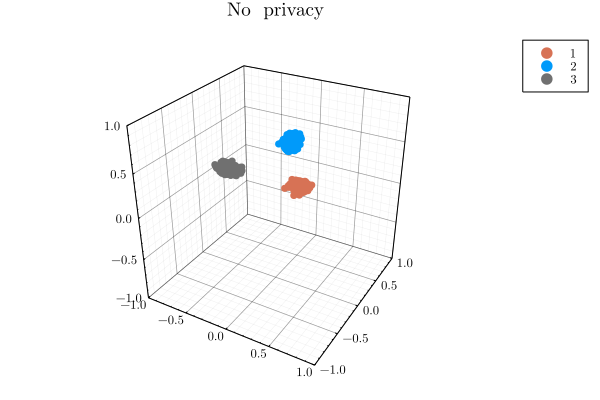

In [7]:
X, _, _ = rdpg.spectralEmbed(A, d=3, scale=false)
plt = @pipe [tuple(x...) for x in eachrow(X)]  |> scatter(_, groups=Z, lim = (-1,1), title="No  privacy")

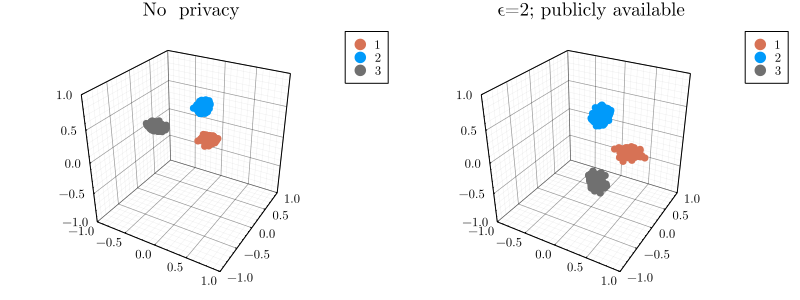

In [8]:
A_private = rdpg.edgeFlip(A, ϵ=ϵ)

A_with_eps = (A_private .- rdpg.privacy(ϵ=ϵ)) ./ (1 - 2 * rdpg.privacy(ϵ=ϵ))
X_with_eps, _ = rdpg.spectralEmbed(A_with_eps, d=3, scale=false)
plt_with_eps = @pipe [tuple(x...) for x in eachrow(X_with_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly available", lim=(-1, 1))

plot(plt, plt_with_eps, layout=(1, 2), size=(800,300))

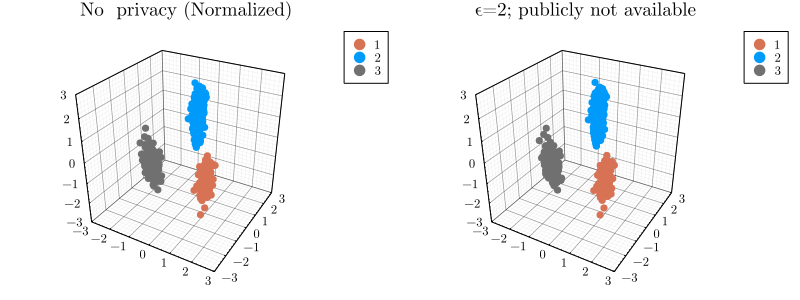

In [9]:
plt_standardized = @pipe [tuple(x...) for x in eachrow(StatsBase.standardize(ZScoreTransform, X, dims=1))] |> scatter(_, groups=Z, lim=(-3, 3), title="No  privacy (Normalized)")

X_without_eps, _ = rdpg.spectralEmbed(A_private, d=3, scale=false)
X_without_eps = StatsBase.standardize(ZScoreTransform, X_without_eps, dims=1)
plt_without_eps = @pipe [tuple(x...) for x in eachrow(X_without_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly not available", lim=(-3, 3))

plot(plt_standardized, plt_without_eps, layout=(1, 2), size=(800, 300))

## Comparison with [Seif at al. (2022)](https://arxiv.org/abs/2202.00636)

In the following, for a stochastic blockmodel with $C=3$ clusters, we examine the bottleneck distance as a function of the number of vertices $n$ when $\epsilon_n \asymp \log^k(n)$ for $k \in \{\frac 23, \frac 34, 1\}$. The result in [Seif at al. (2022)](https://arxiv.org/abs/2202.00636) requires that $\epsilon_n \asymp (\log(n)))$. 

For more information on differentially-private community detection using persistence diagrams, please see [the clustering Jupyter notebook](./clustering.ipynb).

In [12]:
# Ks = [0.5, 0.75, 1.00]
Ks = [0.5]
# N = [500:500:5_000...; 10_000; 25_000]#; 2500:500:5000...]
N = [10_000; 25_000; 50_000]#; 2500:500:5000...]
params = (; p=0.8, r=0.1, clust=3, d=2, order=1, q=Inf, ribbon=true)

(p = 0.8, r = 0.1, clust = 3, d = 2, order = 1, q = Inf, ribbon = true)

### Dense Regime

$$
\mathbb{E}(\mathbf{A}_{ij}) = \Theta(1)
$$

In [13]:
results_dense = simulations(Ks, N, params=params, repeats=3, method=:dense);

Progress: 100%|█████████████████████████████████████████| Time: 0:14:06


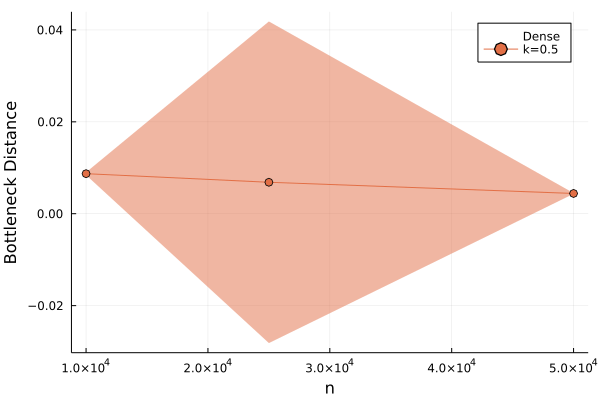

In [14]:
theme(:default)
plt_dense = plot(0, 0, title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")
plt_dense = plot(plt_dense, N, x -> 0, la=0, label="Dense")

for (k, x, y) in zip(Ks, eachrow(results_dense[1]), eachrow(results_dense[2]))
    plt_dense = plot(plt_dense, N, x, ribbon= (params.ribbon ? 0.5 : 0) .* y, label="k=$k", m=:o)
end
plt_dense

----
### Sparse Regime

$$
\mathbb{E}(\mathbf{A}_{ij}) = \Theta\left(\frac{\log n}{n}\right)
$$

In [ ]:
results_sparse = simulations(Ks, N, params=params, repeats=3, method=:sparse);

Progress:  67%|███████████████████████████▍             |  ETA: 0:03:32

In [ ]:
theme(:default)
plt_sparse = plot(0, 0, title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")
plt_sparse = plot(plt_sparse, N, x -> 0, la=0, label="Sparse")
for (k, x, y) in zip(Ks, eachrow(results_sparse[1]), eachrow(results_sparse[2]))
    plt_sparse = plot(plt_sparse, N,  x, ribbon= (params.ribbon ? 0.5 : 0) .* y, label="k=$k", m=:o)
end
plt_sparse

In [ ]:
sz = (400, 300)
# lim = (-0.01, 2.0)
plt_dense = plot(plt_dense, size=sz)
plt_sparse = plot(plt_sparse, size=sz)
savefig(plt_dense, plotsdir("dense.pdf"))
savefig(plt_sparse, plotsdir("sparse.pdf"))